In [1]:
#
import numpy as np
import scipy.io as sio
import scipy.misc
from keras.preprocessing import image
from skimage.transform import rotate, resize
from skimage.measure import label, regionprops
from time import time
from utils import pro_process, BW_img
from PIL import Image
from matplotlib.pyplot import imshow
%matplotlib inline

import cv2

import Model_DiscSeg as DiscModel
import Model_MNet as MNetModel

DiscROI_size = 800
DiscSeg_size = 640
CDRSeg_size = 400


DiscSeg_model = DiscModel.DeepModel(size_set=DiscSeg_size)
DiscSeg_model.load_weights('Model_DiscSeg_ORIGA_pretrain.h5')

CDRSeg_model = MNetModel.DeepModel(size_set=CDRSeg_size)
CDRSeg_model.load_weights('Model_MNet_ORIGA_pretrain.h5')

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


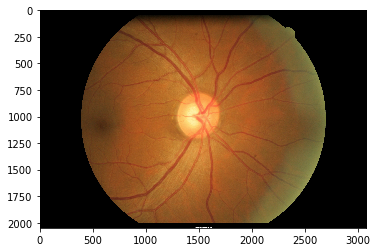

In [2]:
data_img_path = './test_img/'
img_name = 'CS50041_R.jpg'

org_img = np.asarray(image.load_img(data_img_path + img_name))
img_scale = 2048.0 / org_img.shape[0] 
org_img2 = resize(org_img, (2048, int(org_img.shape[1]*img_scale), 3))
imshow(org_img2)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


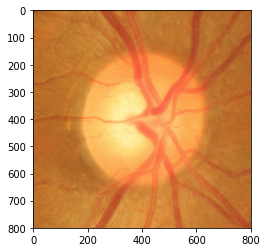

In [3]:
temp_img = resize(org_img, (DiscSeg_size, DiscSeg_size, 3))*255
temp_img = np.reshape(temp_img, (1,) + temp_img.shape)
[prob_6, prob_7, prob_8, prob_9, prob_10] = DiscSeg_model.predict([temp_img])

disc_map = BW_img(np.reshape(prob_10, (DiscSeg_size, DiscSeg_size)), 0.5)

regions = regionprops(label(disc_map))
C_x = regions[0].centroid[0] * org_img.shape[0] / DiscSeg_size
C_y = regions[0].centroid[1] * org_img.shape[1] / DiscSeg_size
disc_region = org_img[int(C_x-DiscROI_size/2):int(C_x+DiscROI_size/2),
              int(C_y-DiscROI_size/2):int(C_y+DiscROI_size/2), ]

imshow(disc_region)

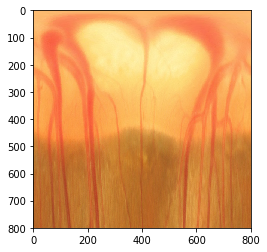

In [4]:
Disc_flat = rotate(cv2.linearPolar(disc_region, (DiscROI_size/2, DiscROI_size/2), DiscROI_size/2, cv2.WARP_FILL_OUTLIERS), -90)
imshow(Disc_flat)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


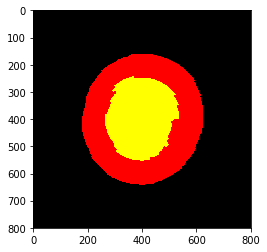

In [5]:
temp_img = pro_process(Disc_flat, CDRSeg_size)
temp_img = np.reshape(temp_img, (1,) + temp_img.shape)
[prob_6, prob_7, prob_8, prob_9, prob_10] = CDRSeg_model.predict(temp_img)
prob_map = np.reshape(prob_10, (prob_10.shape[1], prob_10.shape[2], prob_10.shape[3]))
disc_map = scipy.misc.imresize(prob_map[:, :, 0], (DiscROI_size, DiscROI_size))
cup_map = scipy.misc.imresize(prob_map[:, :, 1], (DiscROI_size, DiscROI_size))
disc_map[-round(DiscROI_size / 3):, :] = 0
cup_map[-round(DiscROI_size / 2):, :] = 0
disc_map = BW_img(disc_map, 0.5)
cup_map = BW_img(cup_map, 0.5)
De_disc_map = cv2.linearPolar(rotate(disc_map, 90), (DiscROI_size/2, DiscROI_size/2),
                                  DiscROI_size/2, cv2.WARP_FILL_OUTLIERS + cv2.WARP_INVERSE_MAP)
De_cup_map = cv2.linearPolar(rotate(cup_map, 90), (DiscROI_size/2, DiscROI_size/2),
                                 DiscROI_size/2, cv2.WARP_FILL_OUTLIERS + cv2.WARP_INVERSE_MAP)

ROI_result = np.zeros((DiscROI_size, DiscROI_size, 3))
ROI_result[..., 0] = BW_img(De_disc_map, 0.5)
ROI_result[..., 1] = BW_img(De_cup_map, 0.5)
imshow(ROI_result)

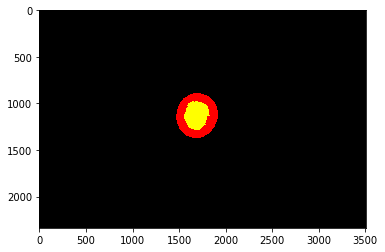

In [6]:
Img_result = np.zeros(org_img.shape)
Img_result[int(C_x-DiscROI_size/2):int(C_x+DiscROI_size/2), 
           int(C_y-DiscROI_size/2):int(C_y+DiscROI_size/2), ] = ROI_result
imshow(Img_result)